In [19]:
import pandas as pd

filepath = "data/ARM_stock_data.csv"
data = pd.read_csv(filepath)

print(data.head())

         Date       Open       High        Low      Close  Adj Close  \
0  2023-09-14  56.099998  66.279999  55.540001  63.590000  63.590000   
1  2023-09-15  68.629997  69.000000  60.750000  60.750000  60.750000   
2  2023-09-18  57.950001  58.741001  55.020000  58.000000  58.000000   
3  2023-09-19  56.250000  56.779999  53.880001  55.169998  55.169998   
4  2023-09-20  55.169998  55.400002  51.520000  52.910000  52.910000   

      Volume  
0  130534500  
1   74568900  
2   34571900  
3   18308600  
4   16369500  


In [20]:
print(data.isnull().sum())

data = data.dropna()

print(data.info())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       306 non-null    object 
 1   Open       306 non-null    float64
 2   High       306 non-null    float64
 3   Low        306 non-null    float64
 4   Close      306 non-null    float64
 5   Adj Close  306 non-null    float64
 6   Volume     306 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 16.9+ KB
None


In [21]:
data['Date'] = pd.to_datetime(data['Date'])

data = data.sort_values(by="Date")

data.to_csv("data/cleaned_ARM_stock_data.csv", index=False)
print("Cleaned data saved!")

Cleaned data saved!


In [22]:
prices = data['Close'].values
print(prices[:10])

[63.59000015 60.75       58.         55.16999817 52.90999985 52.15999985
 51.31999969 54.43999863 53.52000046 52.99000168]


In [23]:
import numpy as np

returns = np.diff(prices) / prices[:-1] # calculating percentage change
print(returns[:10])

[-0.04466111 -0.04526749 -0.04879314 -0.04096426 -0.01417501 -0.0161043
  0.06079499 -0.01689931 -0.00990282  0.04717871]


In [24]:
# Define thresholds for states
def categorize_return(r):
    if r > 0.01:    # Greater than 1% increase
        return "Increase"
    elif r < -0.01:  # Greater than 1% decrease
        return "Decrease"
    else:
        return "No Change"

states = [categorize_return(r) for r in returns]
print(states[:10])  # First 10 states


['Decrease', 'Decrease', 'Decrease', 'Decrease', 'Decrease', 'Decrease', 'Increase', 'Decrease', 'No Change', 'Increase']


In [25]:
from collections import Counter

# Initialize transition matrix
state_space = ["Increase", "Decrease", "No Change"]
transitions = {s: Counter() for s in state_space}

# Count transitions
for (current, next_state) in zip(states[:-1], states[1:]):
    transitions[current][next_state] += 1

# Display raw counts
print(transitions)

{'Increase': Counter({'Increase': 58, 'Decrease': 51, 'No Change': 22}), 'Decrease': Counter({'Increase': 48, 'Decrease': 44, 'No Change': 26}), 'No Change': Counter({'Increase': 25, 'Decrease': 22, 'No Change': 8})}


In [26]:
# Convert counts to probabilities
transition_matrix = {s: {t: count / sum(transitions[s].values()) 
                         for t, count in transitions[s].items()} 
                     for s in state_space}

# Display transition probabilities
print(transition_matrix)


{'Increase': {'Decrease': 0.3893129770992366, 'No Change': 0.16793893129770993, 'Increase': 0.44274809160305345}, 'Decrease': {'Decrease': 0.3728813559322034, 'Increase': 0.4067796610169492, 'No Change': 0.22033898305084745}, 'No Change': {'Increase': 0.45454545454545453, 'No Change': 0.14545454545454545, 'Decrease': 0.4}}


In [27]:
import json

# Save transition matrix
with open("data/transition_matrix.json", "w") as f:
    json.dump(transition_matrix, f)
print("Transition matrix saved!")


Transition matrix saved!


In [28]:
import json

# Load transition matrix
with open("data/transition_matrix.json", "r") as f:
    transition_matrix = json.load(f)

print(transition_matrix)  # Check the matrix structure


{'Increase': {'Decrease': 0.3893129770992366, 'No Change': 0.16793893129770993, 'Increase': 0.44274809160305345}, 'Decrease': {'Decrease': 0.3728813559322034, 'Increase': 0.4067796610169492, 'No Change': 0.22033898305084745}, 'No Change': {'Increase': 0.45454545454545453, 'No Change': 0.14545454545454545, 'Decrease': 0.4}}


In [29]:
import random

# Function to predict the next state
def predict_next_state(current_state, transition_matrix):
    probabilities = transition_matrix[current_state]
    states, probs = zip(*probabilities.items())
    return random.choices(states, probs)[0]

# Test the function
current_state = "Increase"  # Example
next_state = predict_next_state(current_state, transition_matrix)
print(f"From '{current_state}' to '{next_state}'")


From 'Increase' to 'Increase'


In [30]:
# Predict a sequence of states
def predict_state_sequence(start_state, transition_matrix, steps=10):
    state_sequence = [start_state]
    for _ in range(steps):
        next_state = predict_next_state(state_sequence[-1], transition_matrix)
        state_sequence.append(next_state)
    return state_sequence

# Test the sequence prediction
predicted_sequence = predict_state_sequence("Increase", transition_matrix, steps=5)
print("Predicted Sequence:", predicted_sequence)


Predicted Sequence: ['Increase', 'Increase', 'Increase', 'Increase', 'No Change', 'Decrease']


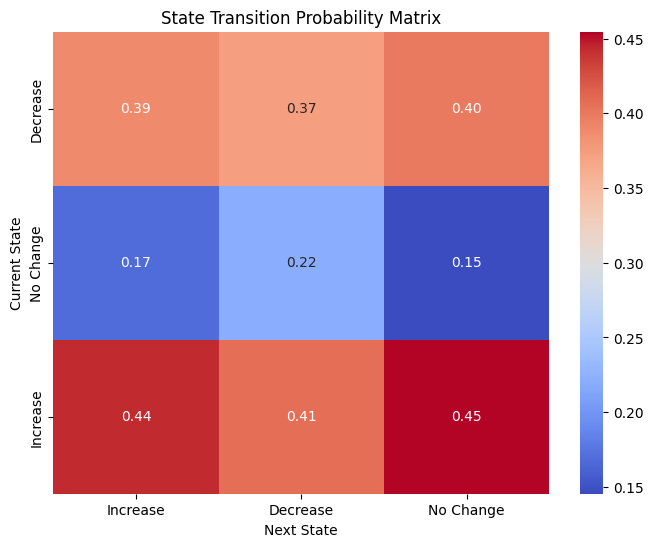

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert transition matrix to a DataFrame
df = pd.DataFrame(transition_matrix).fillna(0)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("State Transition Probability Matrix")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.show()


In [32]:
state_to_change = {"Increase": 1, "Decrease": -1, "No Change": 0}
numerical_changes = [state_to_change[state] for state in predicted_sequence]


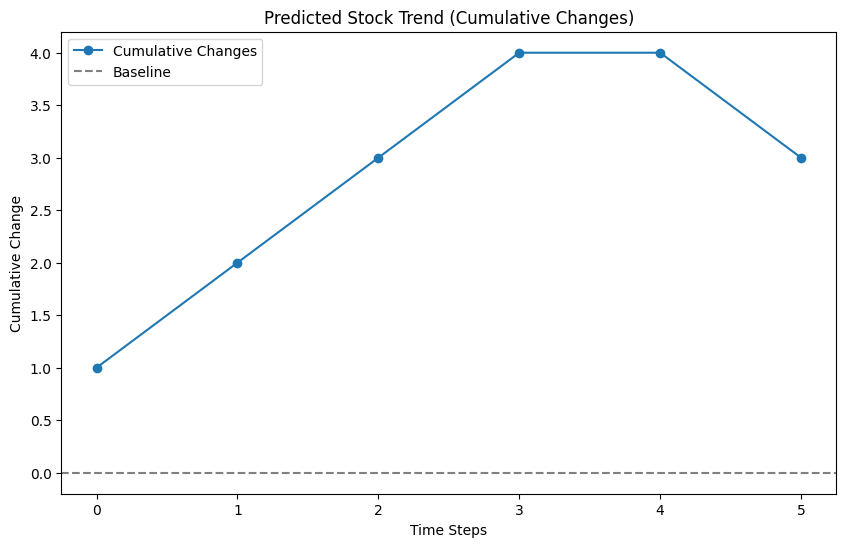

In [33]:
# Calculate cumulative changes
cumulative_changes = [sum(numerical_changes[:i+1]) for i in range(len(numerical_changes))]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_changes, marker="o", label="Cumulative Changes")
plt.axhline(0, color="gray", linestyle="--", label="Baseline")
plt.title("Predicted Stock Trend (Cumulative Changes)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Change")
plt.legend()
plt.show()


In [1]:
# Example rules for buy/sell/hold
def trading_signal(predicted_state):
    if predicted_state == "Increase":
        return "Buy"
    elif predicted_state == "Decrease":
        return "Sell"
    else:
        return "Hold"

# Test the function
print(trading_signal("Increase"))  # Output: Buy


Buy


In [2]:
# Example states (replace with your Markov predictions)
predicted_states = ['Increase', 'Increase', 'Increase', 'Increase', 'No Change', 'Decrease']

# Generate trading signals
signals = [trading_signal(state) for state in predicted_states]
print(signals)


['Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Sell']


In [3]:
# Initial portfolio setup
initial_capital = 10000  # Example starting capital
stock_price = 50  # Example starting price
shares = 0
cash = initial_capital
portfolio_value = []

# Simulate backtesting
for i, signal in enumerate(signals):
    if signal == "Buy" and cash >= stock_price:
        shares += 1
        cash -= stock_price
    elif signal == "Sell" and shares > 0:
        shares -= 1
        cash += stock_price
    portfolio_value.append(cash + shares * stock_price)  # Track portfolio value

print("Final Portfolio Value:", portfolio_value[-1])


Final Portfolio Value: 10000


In [4]:
# Load stock prices
import pandas as pd
data = pd.read_csv("data/cleaned_ARM_stock_data.csv")
prices = data["Close"].values

# Simulate backtesting with actual prices
cash = initial_capital
shares = 0
portfolio_value = []

for i, signal in enumerate(signals):
    price = prices[i]  # Use actual historical price
    if signal == "Buy" and cash >= price:
        shares += 1
        cash -= price
    elif signal == "Sell" and shares > 0:
        shares -= 1
        cash += price
    portfolio_value.append(cash + shares * price)

print("Final Portfolio Value:", portfolio_value[-1])


Final Portfolio Value: 9971.130001068115


In [5]:
cumulative_return = (portfolio_value[-1] - initial_capital) / initial_capital
print(f"Cumulative Return: {cumulative_return * 100:.2f}%")


Cumulative Return: -0.29%


In [6]:
max_drawdown = min(portfolio_value) / max(portfolio_value) - 1
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")


Maximum Drawdown: -0.29%


In [7]:
import numpy as np
daily_returns = np.diff(portfolio_value) / portfolio_value[:-1]
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Sharpe Ratio: -34.92


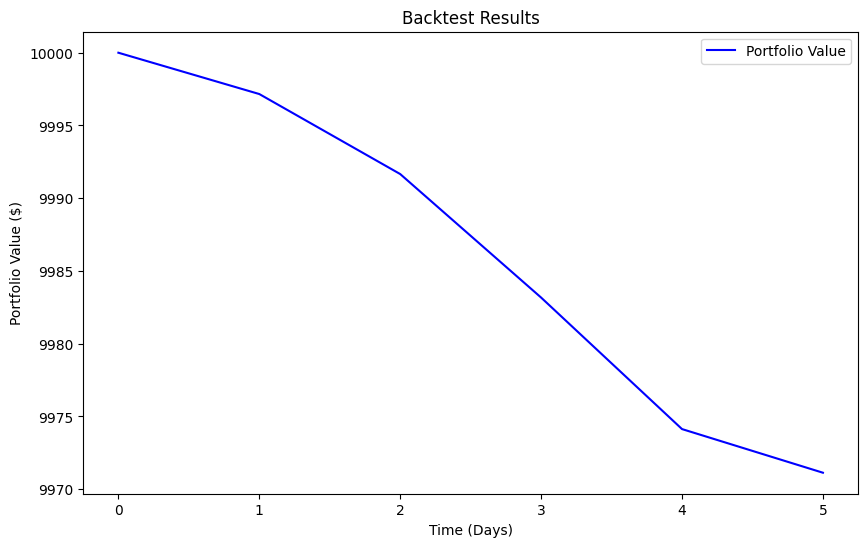

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(portfolio_value, label="Portfolio Value", color="blue")
plt.title("Backtest Results")
plt.xlabel("Time (Days)")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()


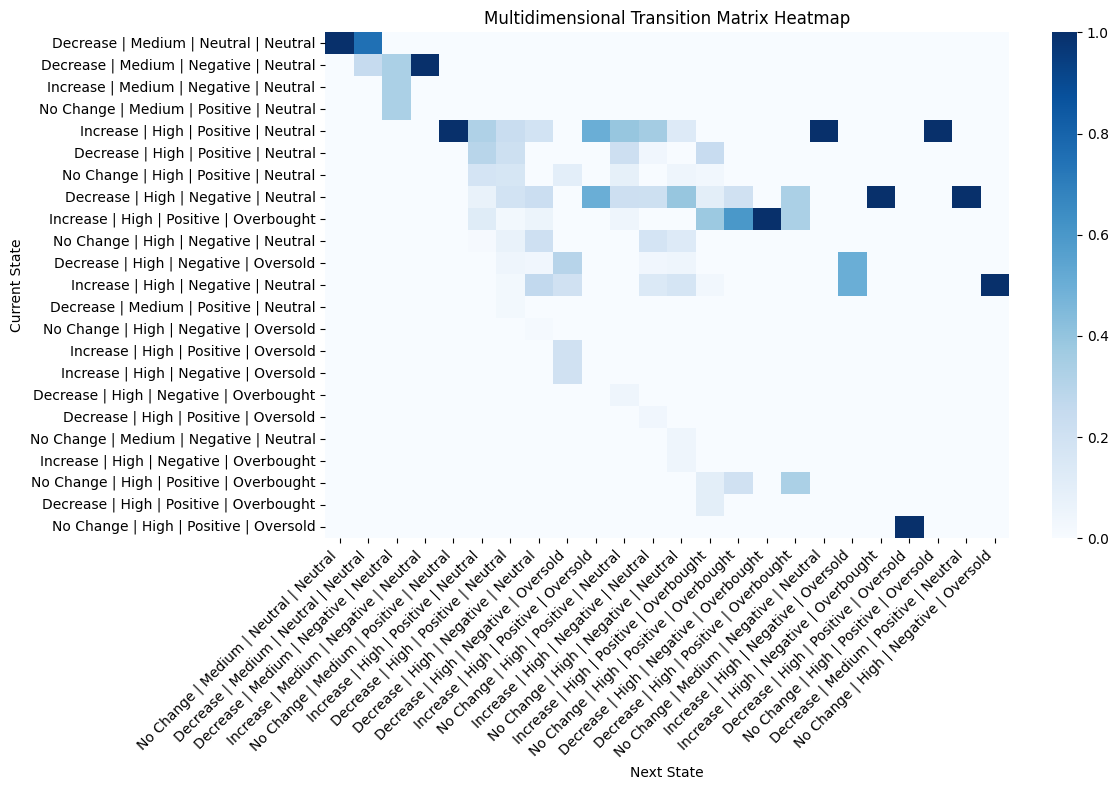

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Load the transition matrix
with open("data/multidimensional_transition_matrix_v2.json", "r") as f:
    transition_matrix = json.load(f)

# Convert to a DataFrame for better visualization
matrix_df = pd.DataFrame(transition_matrix).fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_df, annot=False, cmap="Blues", cbar=True)
plt.title("Multidimensional Transition Matrix Heatmap")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


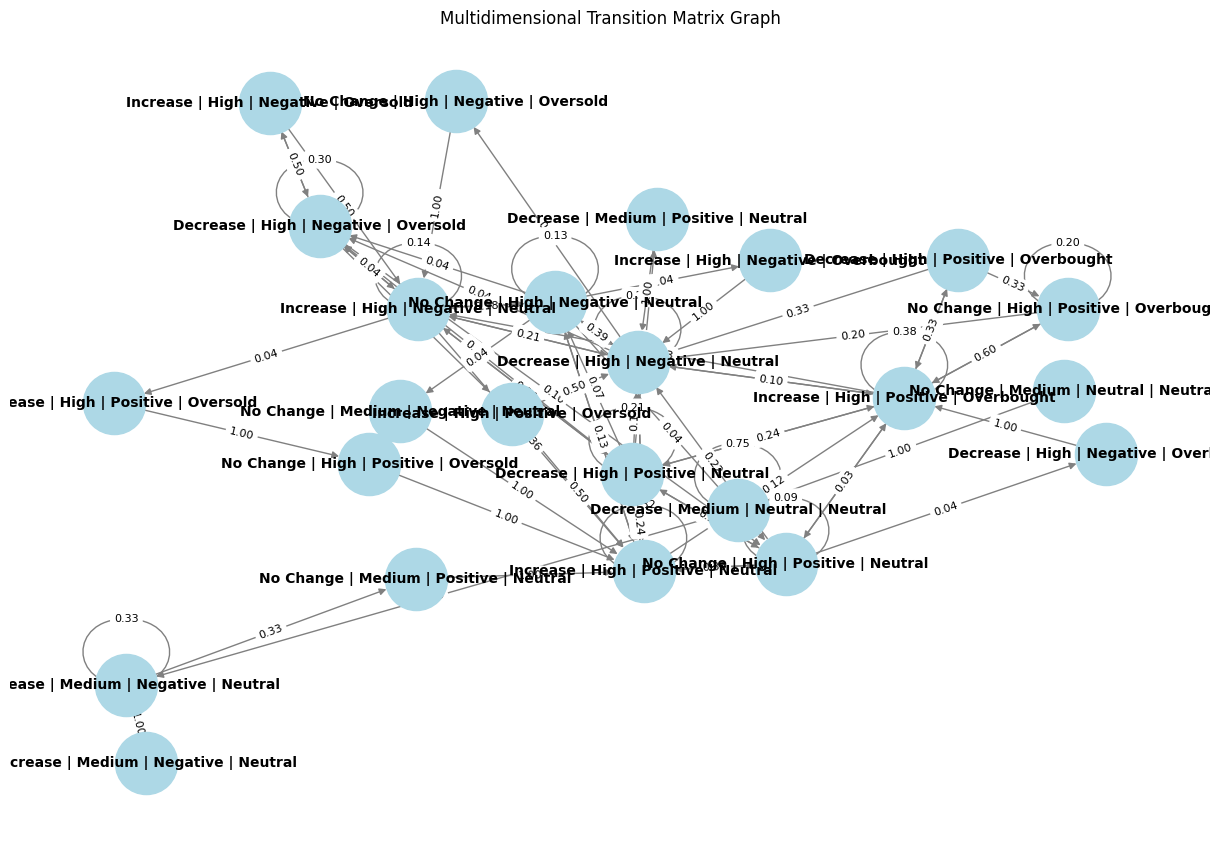

In [3]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges with probabilities
for current_state, transitions in transition_matrix.items():
    for next_state, probability in transitions.items():
        if probability > 0:  # Only include transitions with non-zero probability
            G.add_edge(current_state, next_state, weight=probability)

# Draw the graph
pos = nx.spring_layout(G)  # Use spring layout for better visual separation
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
    edge_color="gray",
)
# Add edge labels for transition probabilities
edge_labels = nx.get_edge_attributes(G, "weight")
formatted_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}  # Format probabilities
nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_labels, font_size=8)

plt.title("Multidimensional Transition Matrix Graph")
plt.show()
